# Modelamiento con sitios CpG

## Librerías y path

In [48]:
import sys
from pathlib import Path
import os

src_path = str(Path.cwd().parents[0] / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

raw_path = str(Path.cwd().parents[0] / "data" / "raw")
preprocess_path = str(Path.cwd().parents[0] / "data" / "preprocessed")


In [49]:
import seaborn as sns    
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [50]:
np.random.seed(42)

## Lectura y preprocesamiento básico

In [51]:
df_gdc = pd.read_csv(f'{preprocess_path}/cpg_preprocessed.csv')

In [52]:
# Pasar a años (Posiblemente redundante, por el uso de minmax(?) )
df_gdc['age'] = df_gdc['age']/365.25
# Escalado
df_gdc['age'] = MinMaxScaler().fit_transform(df_gdc[['age']])

In [53]:
features_to_drop = ['file_id', 'size', 'disease', 'race', 'etnia', 'sample_type']
x, y = df_gdc.drop(columns = features_to_drop), df_gdc['sample_type'].replace({'Primary Tumor':1, 'Solid Tissue Normal':0})

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=42)

## Definición de pipelines

Métodos de selección:
- SVM (lineal)
- ANOVA + RF
- RF iterativo

Métodos de clasificación:
- Red feedforward
- RF, XGB
- SVM (RBF)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif
from imblearn.pipeline import Pipeline
from gene_preprocessing import SelectByIterRF, SelectByPValue
from xgboost import XGBClassifier

In [56]:
anova_fs = [
    ('KBest', SelectPercentile(f_classif, percentile=85)),
    ('P-Value', SelectByPValue()),
    ('Select RF', SelectFromModel(RandomForestClassifier(random_state=42)))
]
sv_fs = [('Select SVM', SelectFromModel(SVC(kernel = 'linear', random_state=42)))]
iter_rf_fs = [('Select RF',SelectByIterRF(thresh=0.99, pos_label=1))]


In [57]:
def fs_pipeline(fs):
    return Pipeline(
        fs
    )

## Clasificación

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from modeling_utils import bar_metrics, fit_estimators_from_dict, predict_from_dict
from modeling_utils import create_dataloaders, simple_binary_train, NeuralNetwork, train_plot
import torch

basic_estimators = {'SVM': SVC(kernel='rbf', random_state=42),
                      'RF':RandomForestClassifier(random_state=42),
                       'XGB': XGBClassifier(random_state=42)}

### Selección con Anova

In [59]:
anova_pipe = fs_pipeline(anova_fs)
anova_pipe.set_output(transform="pandas")
x_anova = anova_pipe.fit_transform(x_train, y_train)
anova_test = anova_pipe.transform(x_test)

x_anova, y_anova = SMOTE().fit_resample(x_anova, y_train)

x_anova.shape

(498, 196)

#### Clasificadores tradicionales

In [60]:
anova_estimators = fit_estimators_from_dict(x_anova, y_anova, basic_estimators)

In [61]:
anova_pred_test = predict_from_dict(anova_test, anova_estimators)

#### Red neuronal

In [62]:
x_anova_train, x_anova_val, y_anova_train, y_anova_val = train_test_split(x_anova, y_anova, train_size=0.8, stratify=y_anova, random_state=42)

In [63]:
train_anova_loader, val_anova_loader, test_anova_loader = create_dataloaders(x_anova_train.values, y_anova_train.values,
 x_anova_val.values, y_anova_val.values, anova_test.values, y_test.values)

In [64]:
ff_anova = NeuralNetwork(in_features = x_anova_train.shape[1])
anova_train_loss, anova_val_loss = simple_binary_train(ff_anova, train_anova_loader, val_anova_loader)

Epoch: 1/50, Train Loss: 0.6903, Val Loss: 0.6818
Epoch: 11/50, Train Loss: 0.0440, Val Loss: 0.0077
Epoch: 21/50, Train Loss: 0.0228, Val Loss: 0.0042
Epoch: 31/50, Train Loss: 0.0155, Val Loss: 0.0306
Epoch: 41/50, Train Loss: 0.0128, Val Loss: 0.0001


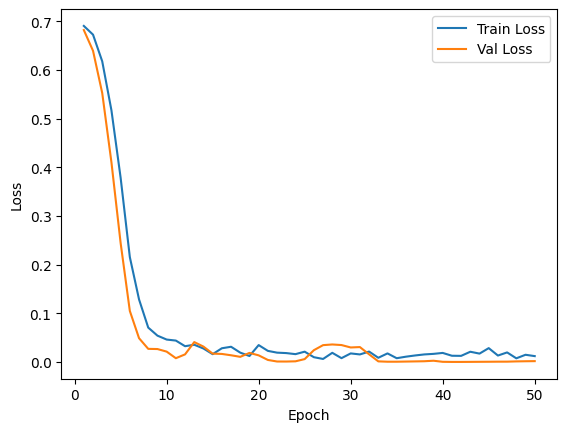

In [65]:
train_plot(anova_train_loss, anova_val_loss)

In [66]:
anova_predict = ff_anova.predict( torch.tensor(anova_test.values, dtype=torch.float32))

#### Métricas

In [67]:
anova_pred_test['Red FF'] = anova_predict

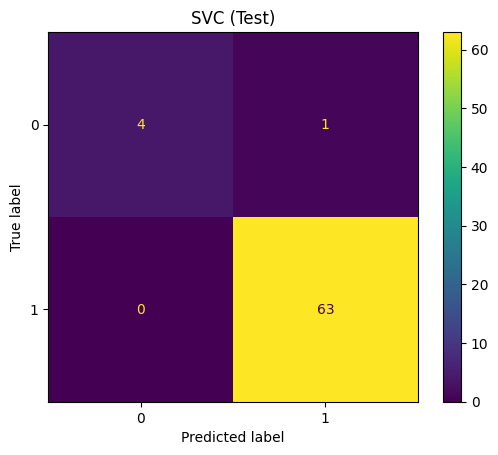

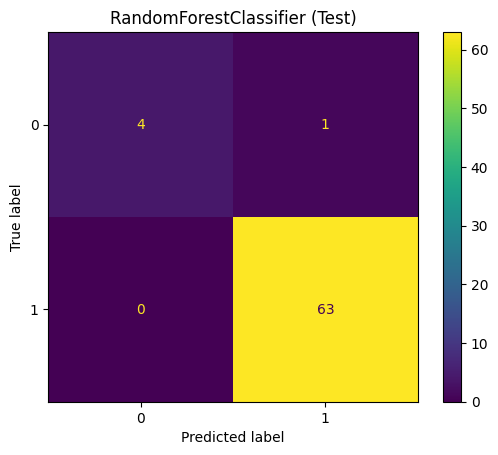

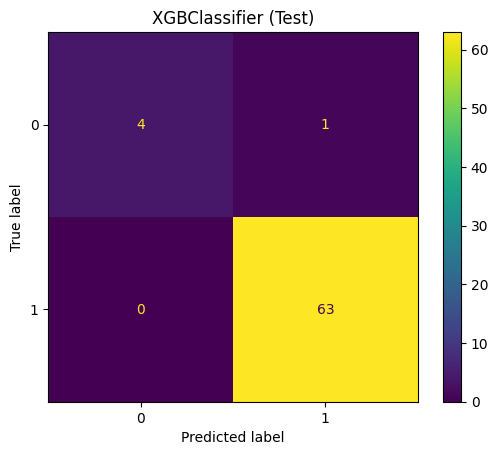

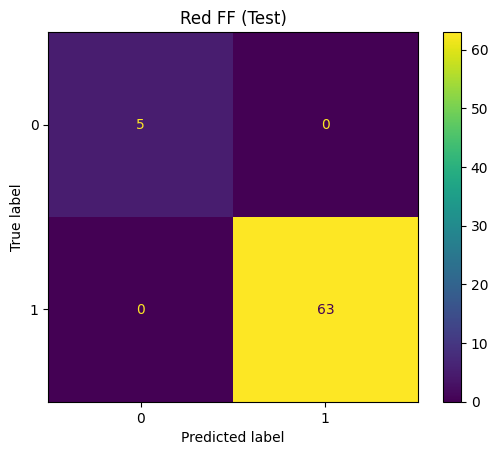

In [68]:
for estim in anova_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, anova_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

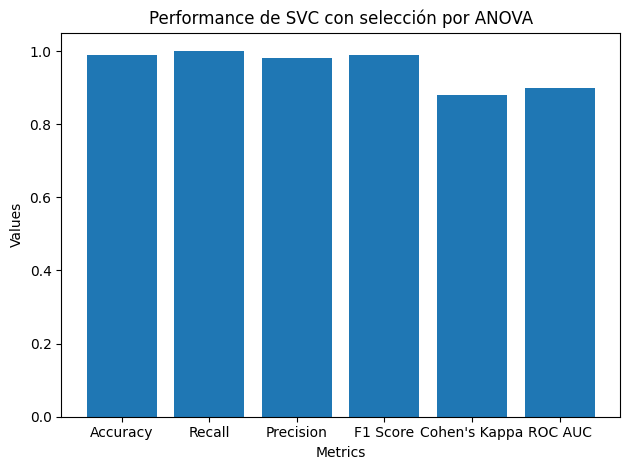

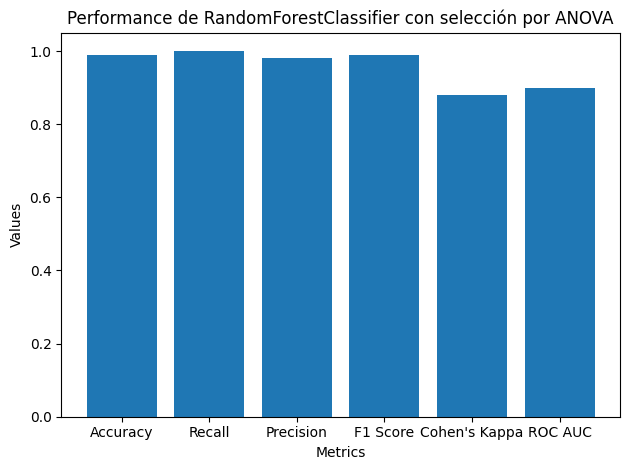

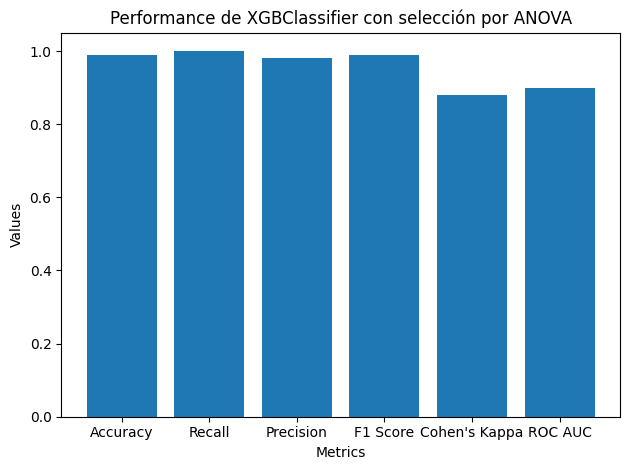

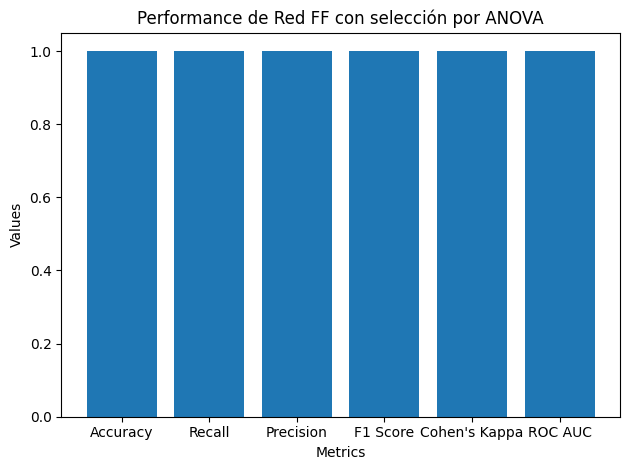

In [69]:
for estim in anova_pred_test:
    bar_metrics(y_test, anova_pred_test[estim], f"Performance de {estim} con selección por ANOVA")

### Selección con SVM

In [70]:
svm_pipe = fs_pipeline(sv_fs)
svm_pipe.set_output(transform="pandas")
x_svm = svm_pipe.fit_transform(x_train, y_train)
svm_test = svm_pipe.transform(x_test)

x_svm, y_svm = SMOTE().fit_resample(x_svm, y_train)
x_svm.shape

(498, 5122)

#### Estimadores tradicionales

In [71]:
svm_estimators = fit_estimators_from_dict(x_svm, y_svm, basic_estimators)

In [72]:
svm_pred_test = predict_from_dict(svm_test, svm_estimators)

#### Red FF

In [73]:
x_svm_train, x_svm_val, y_svm_train, y_svm_val = train_test_split(
    x_svm, y_svm, train_size=0.8, stratify=y_svm, random_state=42)

train_svm_loader, val_svm_loader, test_svm_loader = create_dataloaders(x_svm_train.values, y_svm_train.values,
                                                                       x_svm_val.values, y_svm_val.values, svm_test.values, y_test.values)


Epoch: 1/50, Train Loss: 0.6871, Val Loss: 0.6760
Epoch: 11/50, Train Loss: 0.2353, Val Loss: 0.1800
Epoch: 21/50, Train Loss: 0.1390, Val Loss: 0.0277
Epoch: 31/50, Train Loss: 0.1072, Val Loss: 0.0293
Epoch: 41/50, Train Loss: 0.1404, Val Loss: 0.0289


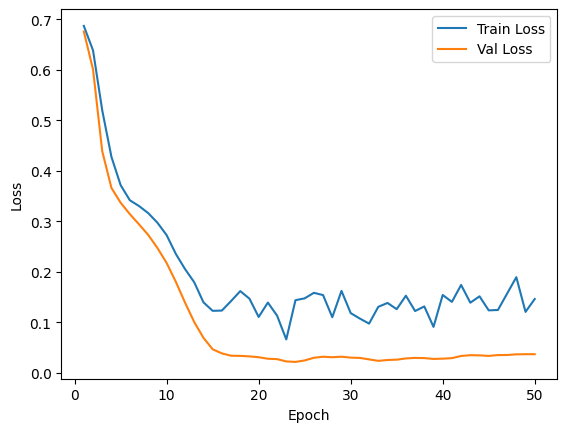

In [74]:
ff_svm = NeuralNetwork(in_features = x_svm_train.shape[1])
svm_train_loss, svm_val_loss = simple_binary_train(ff_svm, train_svm_loader, val_svm_loader)
train_plot(svm_train_loss, svm_val_loss)

In [75]:
svm_predict = ff_svm.predict(torch.tensor(
    svm_test.values, dtype=torch.float32))

#### Métricas

In [76]:
svm_pred_test['Red FF'] = svm_predict

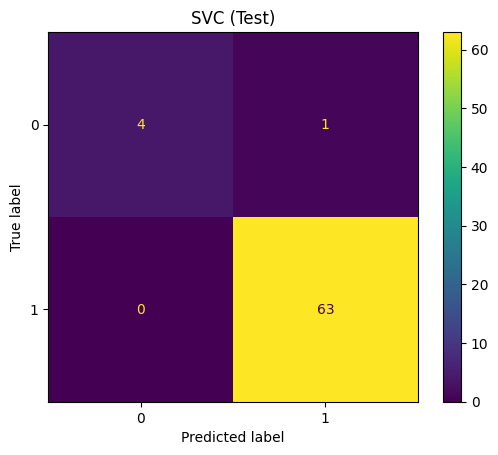

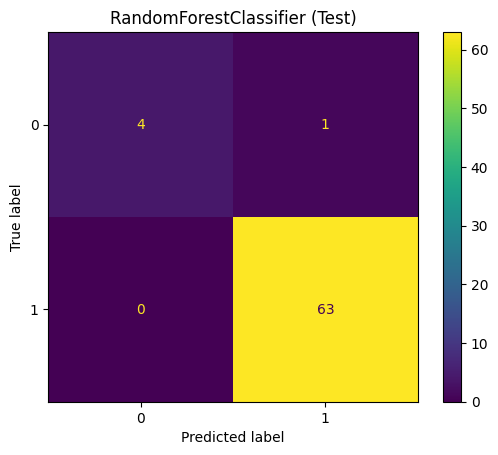

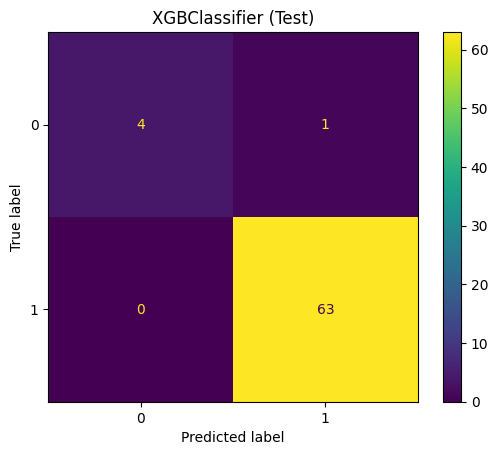

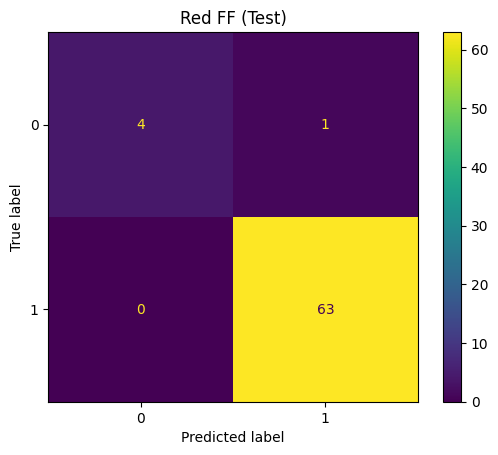

In [77]:
for estim in svm_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, svm_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

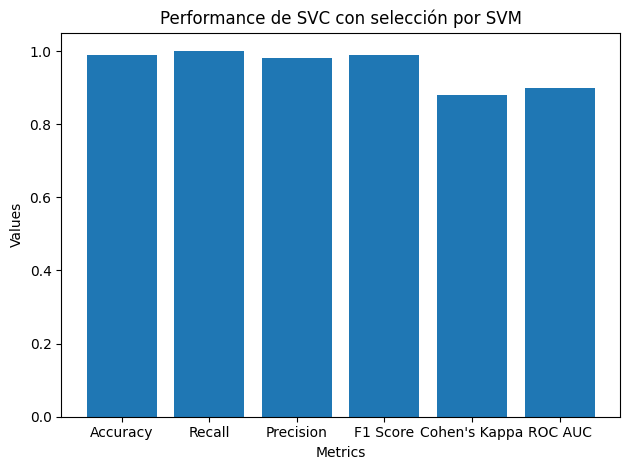

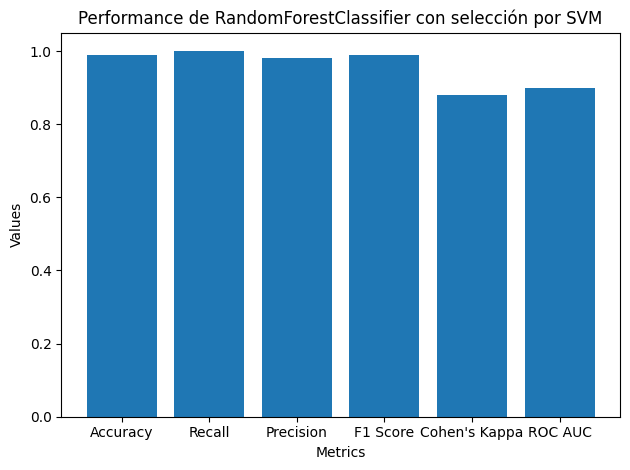

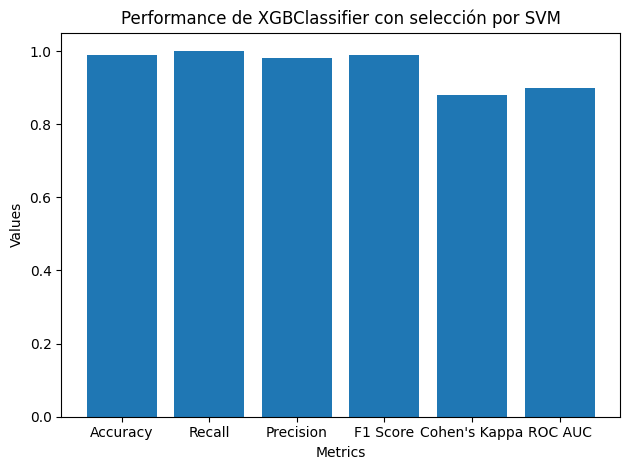

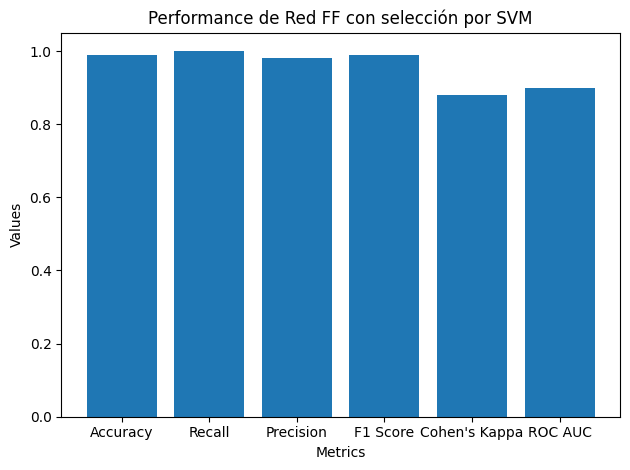

In [78]:
for estim in svm_pred_test:
    bar_metrics(y_test, svm_pred_test[estim], f"Performance de {estim} con selección por SVM")

### Selección con Random Forest iterativo

In [79]:
rf_pipe = fs_pipeline(iter_rf_fs)
rf_pipe.set_output(transform="pandas")
x_rf = rf_pipe.fit_transform(x_train, y_train)
rf_test = rf_pipe.transform(x_test)

x_rf, y_rf = SMOTE().fit_resample(x_rf, y_train)
x_rf.shape

(498, 2713)

#### Estimadores tradicionales

In [80]:
rf_estimators = fit_estimators_from_dict(x_rf, y_rf, basic_estimators)

In [81]:
rf_pred_test = predict_from_dict(rf_test, rf_estimators)

#### Red FF

In [82]:
x_rf_train, x_rf_val, y_rf_train, y_rf_val = train_test_split(
    x_rf, y_rf, train_size=0.8, stratify=y_rf, random_state=42)

train_rf_loader, val_rf_loader, test_rf_loader = create_dataloaders(x_rf_train.values, y_rf_train.values,
                                                                       x_rf_val.values, y_rf_val.values, rf_test.values, y_test.values)


Epoch: 1/50, Train Loss: 0.6901, Val Loss: 0.6607
Epoch: 11/50, Train Loss: 0.0418, Val Loss: 0.0087
Epoch: 21/50, Train Loss: 0.0308, Val Loss: 0.0043
Epoch: 31/50, Train Loss: 0.0254, Val Loss: 0.0089
Epoch: 41/50, Train Loss: 0.0222, Val Loss: 0.0007


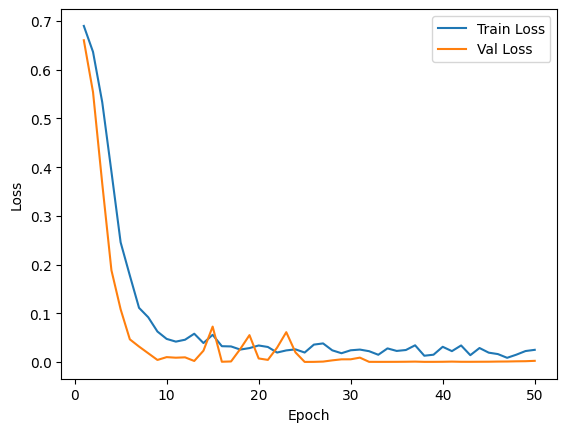

In [83]:
ff_rf = NeuralNetwork(in_features = x_rf_train.shape[1])
rf_train_loss, rf_val_loss = simple_binary_train(ff_rf, train_rf_loader, val_rf_loader)
train_plot(rf_train_loss, rf_val_loss)

In [84]:
rf_predict = ff_rf.predict(torch.tensor(
    rf_test.values, dtype=torch.float32))

### Métricas

In [85]:
rf_pred_test['Red FF'] = rf_predict

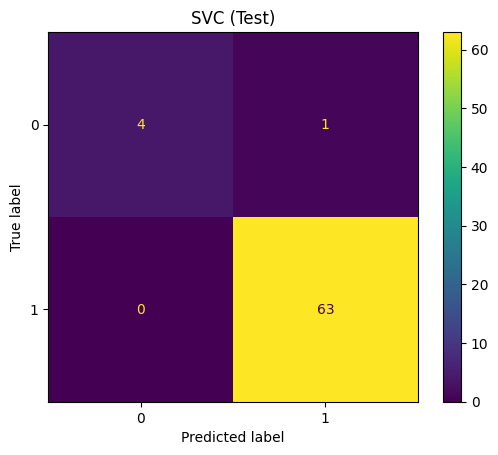

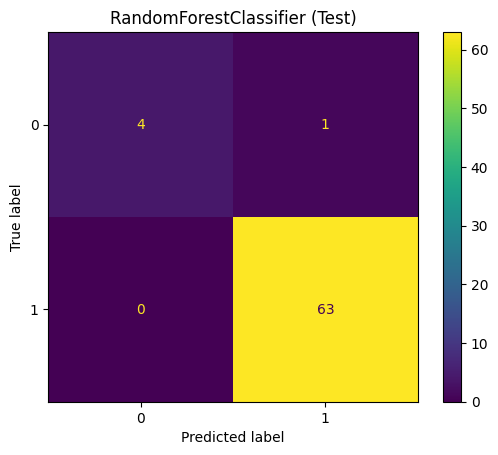

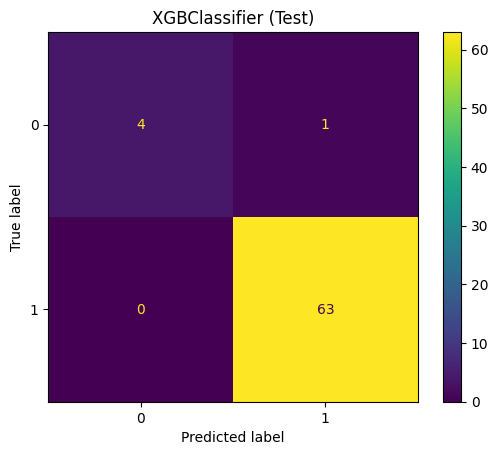

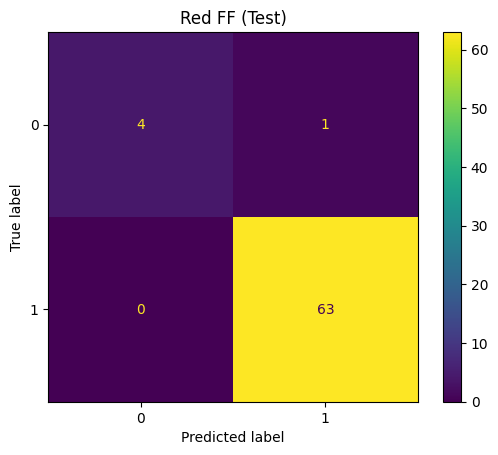

In [86]:
for estim in rf_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, rf_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

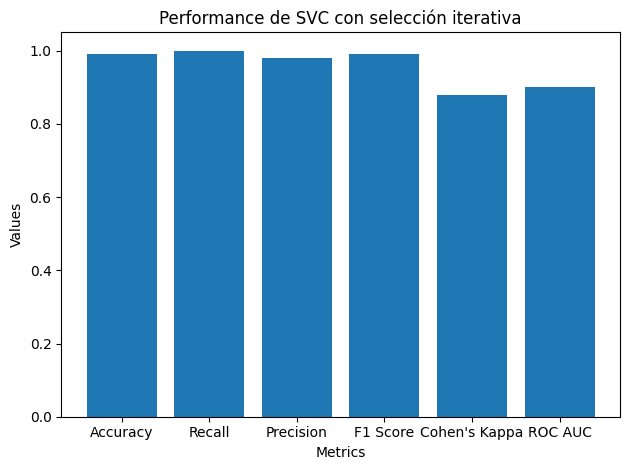

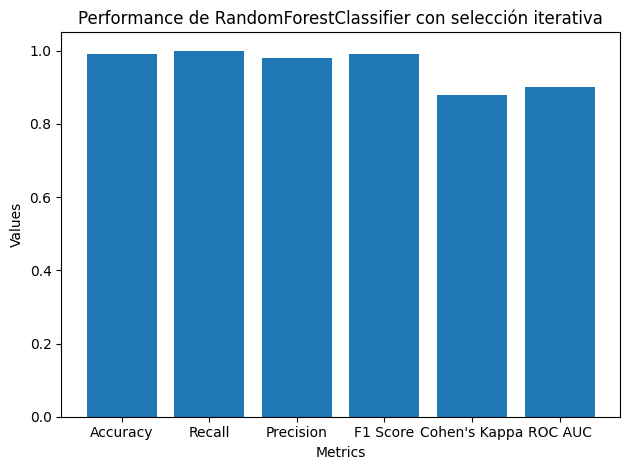

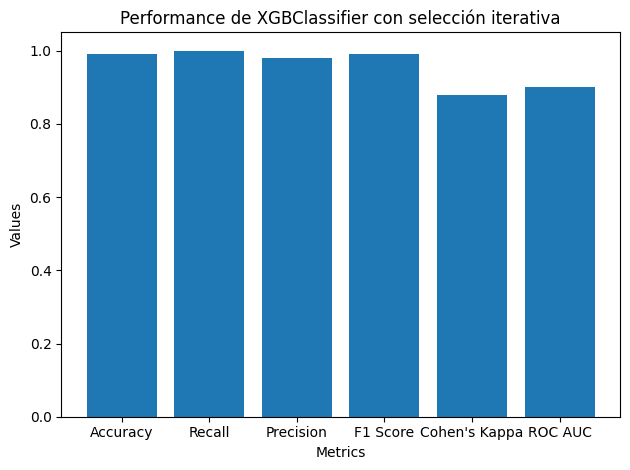

In [25]:
for estim in rf_pred_test:
    bar_metrics(y_test, rf_pred_test[estim], f"Performance de {estim} con selección iterativa")

## Interpretabilidad

In [26]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
